In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re

from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

# Data exploration

Explore the distribution of several variables in the dataset

## Loading data

In [3]:
train = pd.read_csv("/Users/Thms/ds/kaggle/titanic/data/train.csv")
train = train.append(pd.read_csv("/Users/Thms/ds/kaggle/titanic/data/test.csv"))
train = train.reset_index(drop=False)

In [4]:
train.head()

,index,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


#### Data stats

In [5]:
train.dtypes

index            int64
Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object

In [6]:
train.describe()

,index,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1309.000000,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,369.478992,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,248.767105,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.000000,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,163.000000,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,327.000000,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,563.000000,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,890.000000,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


## Vizualizations

#### Survival distribution

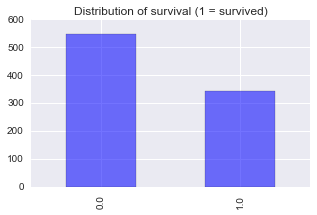

In [7]:
plt.figure(figsize=(5,3))
plt.title("Distribution of survival (1 = survived)")
train[:891]["Survived"].value_counts().plot(kind='bar', alpha=0.55)

#### Classes distribution

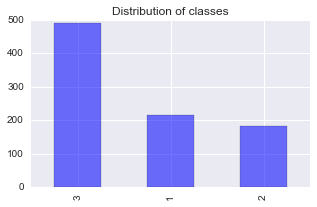

In [8]:
plt.figure(figsize=(5,3))
plt.title("Distribution of classes")
train[:891]["Pclass"].value_counts().plot(kind='bar', alpha=0.55)

#### Survival by age

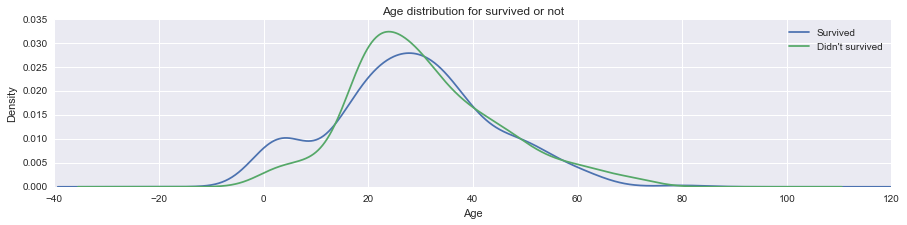

In [9]:
plt.figure(figsize=(15,3))
train[:891]["Age"][train[:891]["Survived"] == 1].plot(kind="kde")
train[:891]["Age"][train[:891]["Survived"] == 0].plot(kind="kde")
plt.xlabel("Age")
plt.title("Age distribution for survived or not")
plt.legend(("Survived", "Didn't survived"), loc="best")

#### Class distribution

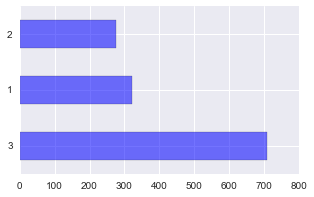

In [10]:
plt.figure(figsize=(5,3))
train["Pclass"].value_counts().plot(kind="barh", alpha=0.55)

#### Age distribution per class

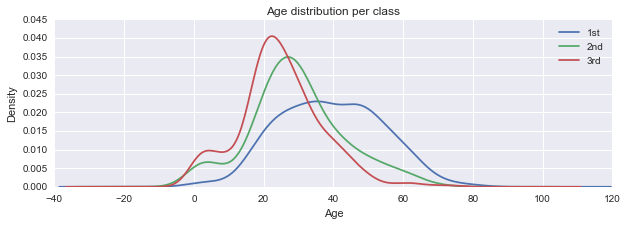

In [11]:
plt.figure(figsize=(10,3))
train["Age"][train["Pclass"] == 1].plot(kind="kde")
train["Age"][train["Pclass"] == 2].plot(kind="kde")
train["Age"][train["Pclass"] == 3].plot(kind="kde")
plt.xlabel("Age")
plt.title("Age distribution per class")
plt.legend(("1st", "2nd", "3rd"))

# Feature engineering (1/2)

## The names

Let's extract passenger titles that could give more information and surnames to represent families.

#### Titles

In [12]:
train["Title"] = train["Name"].apply(lambda s: re.search(', (.*?)\.', s).group(1))

In [13]:
train.groupby(["Sex", "Title"]).size()

Sex     Title       
female  Dona              1
        Dr                1
        Lady              1
        Miss            260
        Mlle              2
        Mme               1
        Mrs             197
        Ms                2
        the Countess      1
male    Capt              1
        Col               4
        Don               1
        Dr                7
        Jonkheer          1
        Major             2
        Master           61
        Mr              757
        Rev               8
        Sir               1
dtype: int64

Combine rare titles together into the "rare title"

In [14]:
rare_titles = ['Dona', 'Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

In [15]:
train["Title"] = train["Title"].apply(lambda title: "rare_title" if title in rare_titles else title)

In [16]:
train["Title"][train["Title"] == 'Mlle'] = "Miss"
train["Title"][train["Title"] == 'Ms'] = "Miss"
train["Title"][train["Title"] == 'Mme'] = "Mrs"

In [17]:
train.groupby(["Sex", "Title"]).size()

Sex     Title     
female  Miss          264
        Mrs           198
        rare_title      4
male    Master         61
        Mr            757
        rare_title     25
dtype: int64

#### Surnames

In [18]:
train["Surname"] = train["Name"].apply(lambda s: s.split(',')[0])

In [19]:
print("There are {} passengers and {} unique surnames".format(len(train), len(train["Surname"].value_counts())))

There are 1309 passengers and 875 unique surnames


## Family variables

#### Family size variable

In [20]:
# Note that we include the passenger himself in the family size
train["Fsize"] = train["SibSp"] + train ["Parch"] + 1

#### Family variable

In [21]:
train["Family"] = train["Surname"] + "_" + train["Fsize"].astype(str)

#### Impact of family size on survival

In [22]:
grouped = train[["Fsize", "Survived"]].groupby("Fsize")

In [23]:
grouped["Survived"].value_counts(1)

Fsize  Survived
1      0           0.473418
       1           0.206329
2      1           0.378723
       0           0.306383
3      1           0.371069
       0           0.270440
4      1           0.488372
       0           0.186047
5      0           0.545455
       1           0.136364
6      0           0.760000
       1           0.120000
7      0           0.500000
       1           0.250000
8      0           0.750000
11     0           0.636364
dtype: float64

We can see that there is a survival penalty to singletons an those with family sizes above 4! Let's collapse this variable into 3 levels since there are fewer large families.

#### Discretize Fsize variable

In [24]:
def discretize(fsize):
    if fsize == 1:
        return "singleton"
    elif 1 < fsize < 5:
        return "small"
    else:
        return "large"

In [25]:
train["FsizeD"] = train["Fsize"].apply(discretize)

(<matplotlib.figure.Figure at 0x1110d51d0>,
 OrderedDict([(('small', '0.0'),
               (0.0, 0.0, 0.3244768921336578, 0.41983343193919809)),
              (('small', '1.0'),
               (0.0,
                0.42315569107541073,
                0.3244768921336578,
                0.57684430892458916)),
              (('singleton', '0.0'),
               (0.3294273871831628,
                0.0,
                0.5967263393005967,
                0.6941479982924702)),
              (('singleton', '1.0'),
               (0.3294273871831628,
                0.69747025742868274,
                0.5967263393005967,
                0.30252974257131715)),
              (('large', '0.0'),
               (0.9311042215332644,
                0.0,
                0.06889577846673557,
                0.83592326653091842)),
              (('large', '1.0'),
               (0.9311042215332644,
                0.83924552566713095,
                0.06889577846673557,
                0.16075447

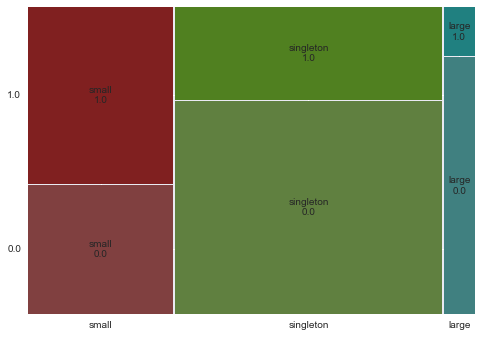

In [26]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(train, ['FsizeD', 'Survived'])

We can visualize easily the survival penalty for singletons and large families.

# Filling missing values

The dataset is very small , we can't afford to delete rows or columns if a value is missing.

#### Embarkment

In [27]:
# Index of missing values in Embarked column 
np.where(train['Embarked'].isnull())[0]

array([ 61, 829])

In [28]:
train.loc[[61,829]]

,index,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,Fsize,Family,FsizeD
61,61,38,B28,NaN,80,"Icard, Miss. Amelie",0,62,1,female,0,1,113572,Miss,Icard,1,Icard_1,singleton
829,829,62,B28,NaN,80,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1,113572,Mrs,Stone,1,Stone_1,singleton


We can infer the embarkment location based on passenger class and fare. They both paid 80$ and are both in class 1.

In [29]:
# Drop the two passengers
embarkment = train[(train["PassengerId"] != 62) & (train["PassengerId"] != 830)]

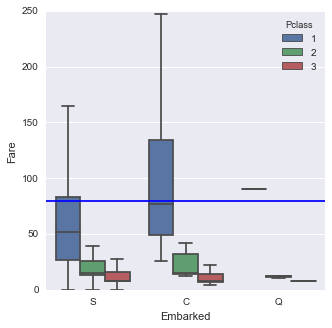

In [30]:
plt.figure(figsize=(5,5))
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=embarkment, showfliers=False)
plt.axhline(y=80, xmin=0, xmax=1, hold=None)

The median fare for a first class passenger departing from Cherbourg is around 80$ so we can safely replace out two missing values by 'C'.

In [31]:
train = train.set_value(61, "Embarked", "C")
train = train.set_value(829, "Embarked", "C")

#### Fare

We have a missing value in the Fare column.

In [32]:
np.where(train['Fare'].isnull())[0]

array([1043])

In [33]:
train.loc[[1043]]

,index,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,Fsize,Family,FsizeD
1043,152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,Storey,1,Storey_1,singleton


Third class passenger who left Southampton. Let's analyse the distribution of the fare for the same profile.

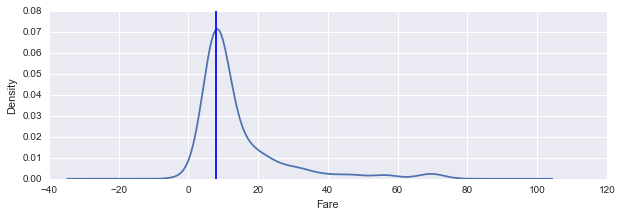

In [34]:
plt.figure(figsize=(10,3))
train["Fare"][(train["Pclass"] == 3) & (train["Embarked"] == "S")].plot(kind="kde")
plt.xlabel("Fare")
plt.axvline(x=8.05, ymin=0, ymax=1, hold=None)

This vizualization tell us than we can replace the NaN value ith the median for their class and embarkment which is $8.05.

In [35]:
median = train["Fare"][(train["Pclass"] == 3) & (train["Embarked"] == "S")].median()
median

8.05

In [36]:
train = train.set_value(1043, "Fare", median)

#### Age

In [37]:
print("We have {} missing values in the column age".format(len(np.where(train['Age'].isnull())[0])))

We have 263 missing values in the column age


There are a lot of missing values for that column. One solution could be to replace all the NaN by the mean or the median of the column but we might lose a lot of information. Instead, We chose to predict those values based on the other variables. I used MICE (Multiple Imputation using Chained Equations) for that. I recommend the `fancyimpute` package to work with missing values, which implement a lot of methods to deal with that problem.

In [38]:
# Use only the useful variables
train_tofill = train[["Age","Pclass", "Sex", "Embarked", "Title","FsizeD", "Fare"]]

In [39]:
# fancyimpute works with matrices of number so we get the dummies of each of them.
train_tofill = pd.get_dummies(train_tofill[["Age", "Pclass", "Sex", "Embarked", "Title", "FsizeD", "Fare"]])

In [40]:
train_tofill[:1]

,Age,Pclass,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_rare_title,FsizeD_large,FsizeD_singleton,FsizeD_small
0,22,3,7.25,0,1,0,0,1,0,0,1,0,0,0,0,1


In [41]:
train_tofill_mat = train_tofill.as_matrix()

In [42]:
from fancyimpute import MICE

train_filled = MICE(verbose=False).complete(train_tofill_mat)

Using Theano backend.


In [43]:
# Extract only the first column which corresponds to the age column that has been filled
age_filled = train_filled[:,0].astype(int)

Let's compare the original distribution of ages and the new one once it's filled to check if we didn't mess with the data in the wrong way.

In [44]:
ages = pd.DataFrame(data=dict(original=train["Age"], filled=pd.Series(age_filled)), index=train["Age"].index)

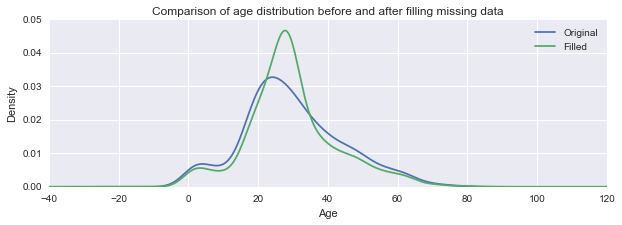

In [45]:
plt.figure(figsize=(10,3))
ages["original"].plot(kind="kde")
ages["filled"].plot(kind="kde")
plt.xlabel("Age")
plt.title("Comparison of age distribution before and after filling missing data")
plt.legend(("Original", "Filled"), loc="best")

Everything looks good, the shape of the distribution is the same, we can replace our missing values.

In [46]:
train["Age"] = ages["filled"]

In [47]:
# No more missing values
len(np.where(train['Age'].isnull())[0])

0

# Feature engineering (2/2)

Now that we have everyone's age, let's create a couple of new variables: **Mother** and **Child**. A child will be a passenger under 18 yo and a mother will be a passenger who is female, over 18, more than 0 children and doesn't have the title "Miss". 

#### Child variable

In [48]:
def child_or_adult(age):
    if age < 18:
        return "Child"
    else:
        return "Adult"

In [49]:
train["Child"] = train["Age"].apply(child_or_adult)

In [50]:
train[["Survived", "Child"]].groupby("Child")["Survived"].value_counts()

Child  Survived
Adult  0           497
       1           281
Child  1            61
       0            52
dtype: int64

Being a child doesn't hurt but doesn't save you either.

#### Mother variable

In [51]:
def isMother(row):
    if row["Sex"] == "female" and row["Parch"] > 0 and row["Age"] >= 18 and row["Title"] == "Miss":
        return "Mother"
    else:
        return "Not Mother"

In [52]:
train["Mother"] = train.apply(lambda row: isMother(row), axis=1)

In [53]:
train[["Survived", "Mother"]].groupby("Mother")["Survived"].value_counts()

Mother      Survived
Mother      1            16
            0            10
Not Mother  0           539
            1           326
dtype: int64

DONE!!!!! We could maybe work with the cabin numbers to extract the deck and use that as an other predictor but there are 77% of missing values in that column.

# Prediction

Finally the fun part! We have a lot of variables to work with and we no longer have missing values. For the prediction model we will rely on the Random Forest classifier which should perform very well on that kind of problem.

The first step is to select only the relevant features and convert them to dummies variable is they are categorical. Then we'll split back out dataset into the training and testing set.

After that, I will use gridsearch to easily tune my classifier. Gridsearch is a very powerful tool which allow us to try a lot of hyperparameters combinations and chose the best one to make the prediction. 

The last step will be to make the prediction on the testing set and submit it to Kaggle.

## Keeping only relevant features and get dummies

In [54]:
dataset = pd.get_dummies(train[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare",
                              "Embarked", "Title", "FsizeD", "Child", "Mother", "Survived"]])

## Split into training and testing set

In [55]:
test = dataset[891:]
train = dataset[:891]

## Building the model

#### Splitting into test and train set

In [56]:
data = train.ix[:, train.columns != 'Survived']
target = train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.30)

#### Define parameter grid

We can act on 3 different parameters in Random Forest

In [57]:
param_grid = {'min_samples_split': [1], # We chose 1 because it will be the best value for this parameter
              'min_samples_leaf' : np.arange(1, 5),
              'n_estimators' : np.arange(1, 30)}

In [58]:
np.set_printoptions(suppress=True)
print(param_grid)

{'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'min_samples_split': [1], 'min_samples_leaf': array([1, 2, 3, 4])}


#### Building model

In [59]:
# Initialize gridsearch with 10 cross_val (because why not, the data set is small, will be fast)
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1, cv=10)

In [60]:
# Run GS as a normal classifier
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   10.8s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   17.9s


Fitting 10 folds for each of 116 candidates, totalling 1160 fits


[Parallel(n_jobs=1)]: Done 1160 out of 1160 | elapsed:   25.8s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'min_samples_split': [1], 'min_samples_leaf': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [61]:
# Predictions
grid_search.predict(X_test)

array([ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
        0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
        1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,
        0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0

In [62]:
# Score
grid_search.score(X_test, y_test)

0.82835820895522383

83% of accuracy, not bad!

In [63]:
# Best parameters for Random Forest
grid_search.best_params_

{'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 16}

([<matplotlib.axis.YTick at 0x11372bbe0>,
 <a list of 4 Text yticklabel objects>)

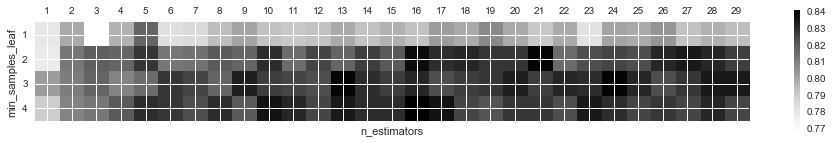

In [64]:
# Visualize the results 
scores = [x[1] for x in grid_search.grid_scores_]
scores = np.array(scores).reshape(4, 29)

plt.matshow(scores)
plt.ylabel('min_samples_leaf')
plt.xlabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(29), param_grid['n_estimators'])
plt.yticks(np.arange(4), param_grid['min_samples_leaf'])

## Predict

In [73]:
submission = pd.read_csv("/Users/Thms/ds/kaggle/titanic/data/test.csv")

In [83]:
submission["Survived"] = grid_search.predict(test.ix[:, test.columns != 'Survived'])
submission["Survived"] = submission["Survived"].apply(int)

In [84]:
submission[["PassengerId", "Survived"]].to_csv("submission.csv", index=False)

This submission perform 79.4% of accuracy. I really think it's harder to make better than 85% on this competition given the small size of the dataset and the limited number of features.